In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.optimizers import Adam

import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Reshape, LSTM
from keras import backend as K
import itertools
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [84]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000

In [3]:
base_skin_dir = os.path.join('..', 'input/skin-cancer-mnist-ham10000')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
skin_df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
skin_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
1933,HAM_0007305,ISIC_0029933,mel,histo,45.0,female,upper extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanoma,5
941,HAM_0005749,ISIC_0032843,bkl,consensus,85.0,male,back,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4816,HAM_0002444,ISIC_0029852,nv,follow_up,35.0,female,upper extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4
5876,HAM_0000774,ISIC_0029707,nv,follow_up,55.0,female,lower extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4
1773,HAM_0001274,ISIC_0032462,mel,histo,70.0,male,upper extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanoma,5
4912,HAM_0002863,ISIC_0024769,nv,follow_up,50.0,male,back,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4
7664,HAM_0003966,ISIC_0033731,nv,histo,35.0,female,foot,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4
163,HAM_0005386,ISIC_0033505,bkl,histo,45.0,male,back,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2463,HAM_0003220,ISIC_0034093,bcc,histo,80.0,female,face,../input/skin-cancer-mnist-ham10000/ham10000_i...,Basal cell carcinoma,1
8572,HAM_0001327,ISIC_0032489,nv,histo,45.0,male,abdomen,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4


In [6]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [7]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

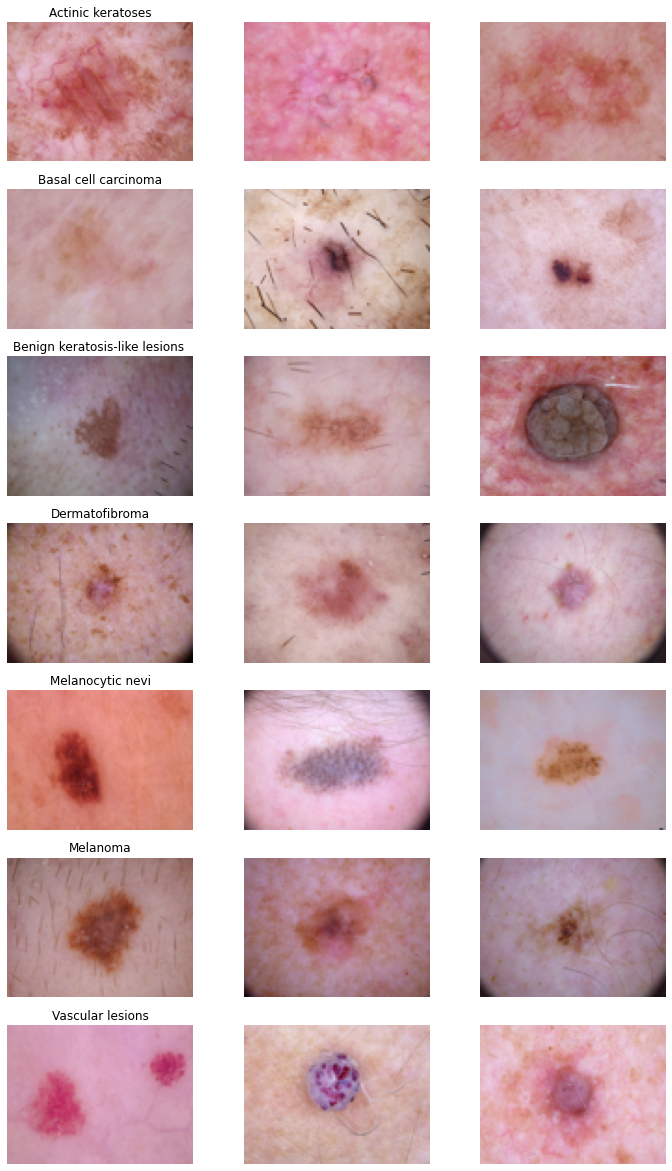

In [68]:
n_samples = 3
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [8]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [9]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=23)

In [10]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [11]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [12]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 23)

In [13]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  

datagen.fit(x_train)

CNN model

In [15]:
input_shape = (75, 100, 3)
num_classes = 7
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu',))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes,activation = 'softmax'))

2023-02-02 15:30:53.294722: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 64)       1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 100, 64)       256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 64)       36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 100, 64)       256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 37, 50, 128)       5

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=6)
mod_chckpt = ModelCheckpoint(filepath='model_v1_rms.h5', monitor='val_loss', save_best_only=True)

In [20]:
epochs = 10
batch_size = 50

history= model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                                epochs = epochs, validation_data = (x_validate,y_validate),
                                verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                                callbacks=[learning_rate_reduction, early_stop, mod_chckpt])

2023-02-02 15:31:23.784645: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
144/144 [==============================] - 542s 4s/step - loss: 1.3041 - accuracy: 0.6211 - val_loss: 1.3850 - val_accuracy: 0.6309
Epoch 2/10
144/144 [==============================] - 541s 4s/step - loss: 0.7982 - accuracy: 0.7168 - val_loss: 1.5344 - val_accuracy: 0.6559
Epoch 3/10
144/144 [==============================] - 539s 4s/step - loss: 0.7572 - accuracy: 0.7194 - val_loss: 0.9020 - val_accuracy: 0.7045
Epoch 4/10
144/144 [==============================] - 538s 4s/step - loss: 0.7086 - accuracy: 0.7408 - val_loss: 0.8459 - val_accuracy: 0.7107
Epoch 5/10
144/144 [==============================] - 542s 4s/step - loss: 0.6869 - accuracy: 0.7486 - val_loss: 0.7958 - val_accuracy: 0.7307
Epoch 6/10
144/144 [==============================] - 541s 4s/step - loss: 0.6688 - accuracy: 0.7552 - val_loss: 1.1110 - val_accuracy: 0.6796
Epoch 7/10
144/144 [==============================] - 543s 4s/step - loss: 0.6574 - accuracy: 0.7615 - val_loss: 0.7783 - val_accuracy: 0.7145

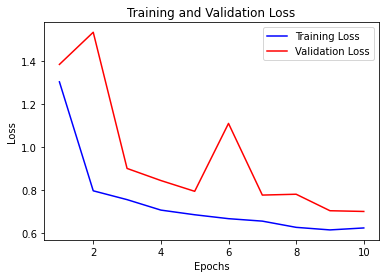

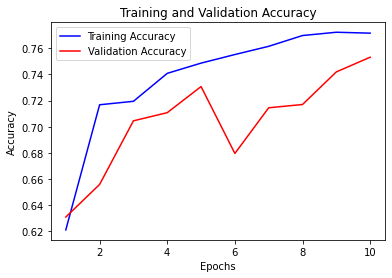

In [21]:
history_dict = history.history
loss_value = history_dict['loss']
val_loss_value = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(loss_value) + 1)
plt.plot(epochs, loss_value, 'b', label='Training Loss')
plt.plot(epochs, val_loss_value, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_adam.png')
plt.show()

plt.figure()

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_adam.png')
plt.show()

In [22]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save('adam_model.h5')

26/26 [==============================] - 15s 579ms/step - loss: 0.7023 - accuracy: 0.7531
Validation: accuracy = 0.753117  ;  loss_v = 0.702280
Test: accuracy = 0.751872  ;  loss = 0.723343


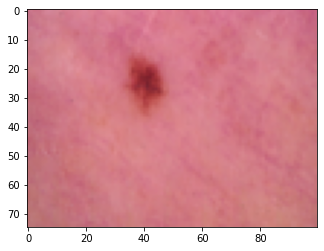

In [87]:
plt.imshow(((x_test[5]*x_test_std)+x_test_mean).astype('int'))

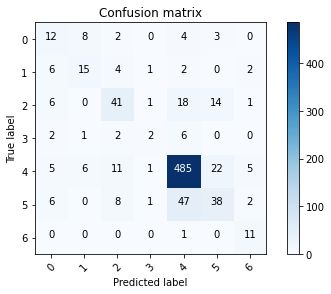

In [26]:
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_validate,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

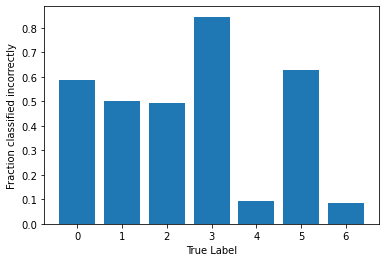

In [27]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

CNN+LSTM model

In [48]:
model2 = Sequential()
model2.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
model2.add(BatchNormalization())
model2.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu',))
model2.add(BatchNormalization())
model2.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Flatten())
model2.add(Reshape((9*16,192)))
model2.add(LSTM(units=32))
model2.add(Dense(64, activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dense(num_classes,activation = 'softmax'))

In [49]:
optimizer2 = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model2.compile(optimizer = optimizer2 , loss = "categorical_crossentropy", metrics=["accuracy"])

In [51]:
epochs = 3
batch_size = 50

history2= model2.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                                epochs = epochs, validation_data = (x_validate,y_validate),
                                verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                                callbacks=[learning_rate_reduction, early_stop, mod_chckpt])

Epoch 1/3
144/144 [==============================] - 558s 4s/step - loss: 1.3762 - accuracy: 0.5609 - val_loss: 1.2009 - val_accuracy: 0.6496
Epoch 2/3
144/144 [==============================] - 563s 4s/step - loss: 1.0383 - accuracy: 0.6553 - val_loss: 1.0373 - val_accuracy: 0.6484
Epoch 3/3
144/144 [==============================] - 562s 4s/step - loss: 0.9842 - accuracy: 0.6640 - val_loss: 1.0016 - val_accuracy: 0.6671


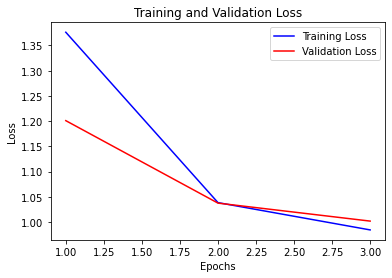

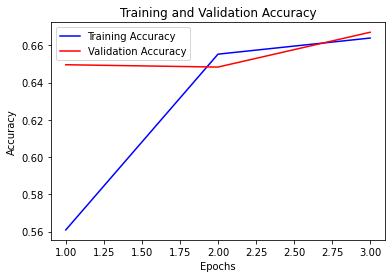

In [52]:
history_dict = history2.history
loss_value = history_dict['loss']
val_loss_value = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(loss_value) + 1)
plt.plot(epochs, loss_value, 'b', label='Training Loss')
plt.plot(epochs, val_loss_value, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_lstm.png')
plt.show()

plt.figure()

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_lstm.png')
plt.show()

In [53]:
loss, accuracy = model2.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model2.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save('lstm_model.h5')

26/26 [==============================] - 18s 676ms/step - loss: 1.0016 - accuracy: 0.6671
Validation: accuracy = 0.667082  ;  loss_v = 1.001646
Test: accuracy = 0.661508  ;  loss = 0.977769


In [55]:
print(f"Predicted {np.argmax(model2.predict(x_test[1].reshape(-1,75,100,3)))}\nActual {np.argmax(y_test[1])}")

Predicted 4
Actual 4


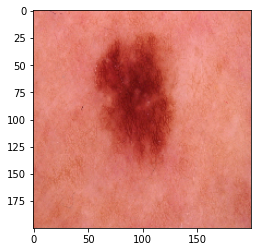

Prediction: Melanocytic nevi


In [80]:
from skimage import io
from keras.preprocessing import image
img = image.load_img('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026899.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026899.jpg', grayscale=False, target_size=(200, 200))
disease_class = [ 'Melanocytic nevi','Melanoma','Benign keratosis-like lesions ','Basal cell carcinoma','Actinic keratoses','Vascular lesions','Dermatofibroma']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255


plt.imshow(show_img)
plt.show()

a=0
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])